### ESN application: El-Nino Southern Oscillation (ENSO)

Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). 

SST data: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

Data contains **monthly mean SST** from 1854 .. 2021, in a 2° by 2° lat/lon grid:  
**lat:** 88N .. -88N (= 88S)  
**lon:** 0E .. 358E

Start from 1880, as in [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability".

**Outline**

- Calculate ENSO index
- Predict events (El Nino / La Nina / neutral) from ENSO index
- Optimize baseESN, try DeepESN and other ANN architectures for comparison

### Tech preamble

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
import tensorflow.keras.initializers as tfi
from tensorflow.keras.utils import plot_model

# Work with my own library of useful ESN functions
from ESN_functions_v02 import *

### Load SST data

In [2]:
# Use, when working with relative path on local machine (or nesh)
sst_path = "../data/sst.mnmean.nc"
sst_dataset = xr.open_dataset(sst_path)
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2015, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-12-06

### Calculating ENSO index from sst data

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. Paper [Morrow et al., 2010] shows index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

In [3]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01')).sel(lat=slice(5,-5)).sel(lon=slice(190,240)).mean(("lat", "lon"))

In [4]:
# Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño 3.4 region
sst_climatology = (
    sst_dataset.sst
    .sel(time=slice('1950-01-01','1979-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon", "time"))
)

In [5]:
# Compute std dev in ime for monthly climatology (e.g., 1950-1979), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_std = (
    sst_dataset.sst
    .sel(time=slice('1950-01-01','1979-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

In [10]:
# Subtract climatology from area averaged total SST time series to obtain anomalies
sst_anomaly = sst_mean - sst_climatology

In [11]:
# Smooth the anomalies with a 5-month running mean to get ENSO index
ENSO_index = sst_anomaly.rolling(time=5, center=True).mean().dropna("time")

In [12]:
# Recipy for calculating ENSO index requires normalization of the smoothed anomalies
# by its standard deviation over the climatological period.
ENSO_index_norm = ENSO_index / sst_climatology_std

<function matplotlib.pyplot.show(close=None, block=None)>

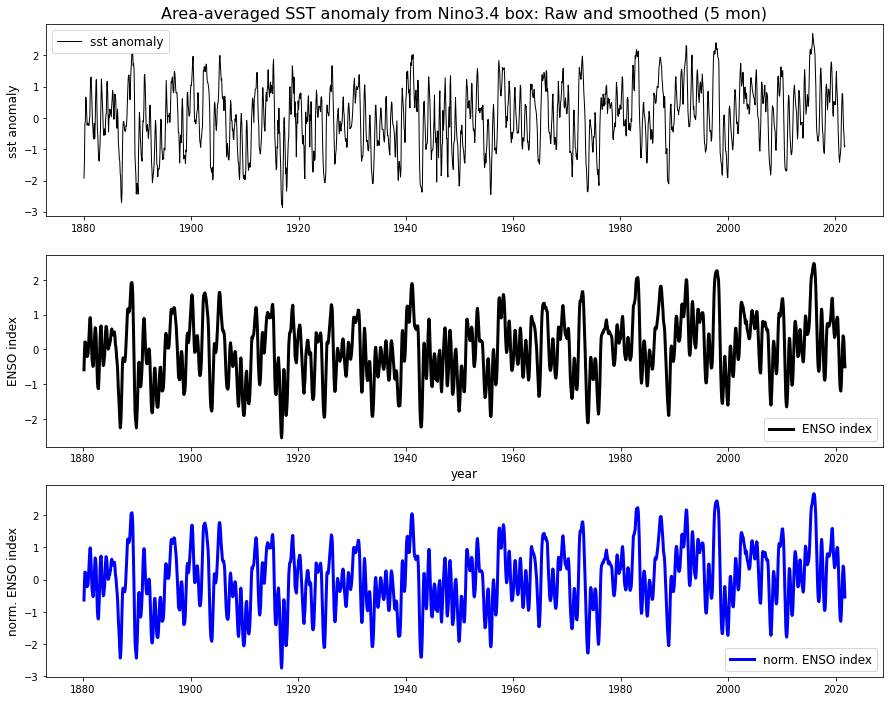

In [13]:
# First glance at raw sst anomaly timeseries and (un-)normalized ENSO index
fig, axes = plt.subplots(3, 1, figsize=(15,12))
axes[0].plot(sst_anomaly.time, sst_anomaly, label='sst anomaly', color='black', linewidth=1)
axes[1].plot(ENSO_index.time, ENSO_index, label='ENSO index', color='black', linewidth=3)
axes[2].plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='blue', linewidth=3)
axes[1].set_xlabel("year", fontsize=12)
axes[0].set_ylabel("sst anomaly", fontsize=12)
axes[1].set_ylabel("ENSO index", fontsize=12)
axes[2].set_ylabel("norm. ENSO index", fontsize=12)
axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)
axes[2].legend(fontsize=12)
axes[0].set_title("Area-averaged SST anomaly from Nino3.4 box: Raw and smoothed (5 mon)", fontsize=16)
plt.show

In [14]:
# Augmented Dickey-Fuller Test on normalized ENSO index: 
# Check, how strong timeseries is determined by possible trend.
ADFT_ENSO = adfuller(ENSO_index_norm)

# Print results from ADFT:
print('\nnorm. ENSO index:')
print('==================')
print('ADF Statistic: %f' % np.round(ADFT_ENSO[0],3))
print('p-value: %f' % np.round(ADFT_ENSO[1],3))


norm. ENSO index:
ADF Statistic: -6.553000
p-value: 0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

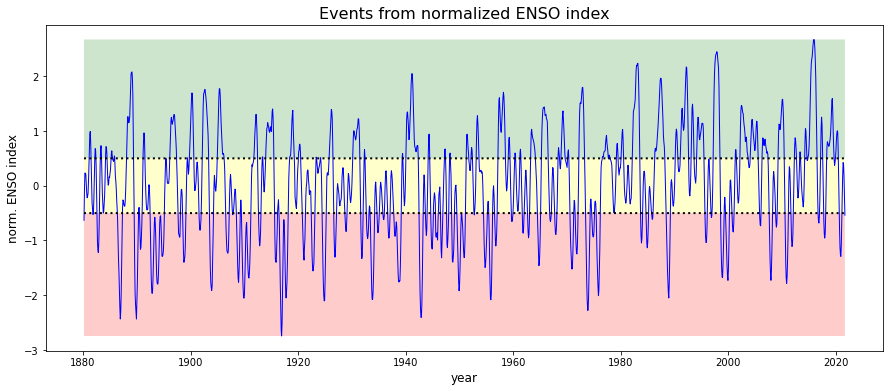

In [15]:
# Get min/max for norm. ENSO index, for plotting shaded areas separating events:
ENSO_min = np.min(ENSO_index_norm)
ENSO_max = np.max(ENSO_index_norm)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='blue', linewidth=1)
axes.set_xlabel("year", fontsize=12)
axes.set_ylabel("norm. ENSO index", fontsize=12)
axes.set_title("Events from normalized ENSO index", fontsize=16)

# Add horizontal lines
axes.plot(ENSO_index_norm.time,0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)
axes.plot(ENSO_index_norm.time,-0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)

# Shade area highlighting distinct events.
axes.fill_between(np.array(ENSO_index_norm.time), 0.5, ENSO_max, facecolor='green', alpha=0.2)
axes.fill_between(np.array(ENSO_index_norm.time), -0.5, ENSO_min, facecolor='red', alpha=0.2)
axes.fill_between(np.array(ENSO_index_norm.time), -0.5, 0.5, facecolor='yellow', alpha=0.2)

plt.show

In [17]:
# Get number of events: Absolute and realtive to ALL events
print("\nnormalmized ENSO index")
print("======================")

print("\nTOTAL number of timesteps: ", len(ENSO_index_norm))
print("number of timesteps connected to EL Nino events: ", np.sum(ENSO_index_norm.values>0.5))
print("number of timesteps connected to La Nina events: ", np.sum(ENSO_index_norm.values<-0.5))
print("number of timesteps connected to neutral events: ", np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)))

print("\nrel. amount of EL Nino events: ", np.round(np.sum(ENSO_index_norm.values>0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of La Nina events: ", np.round(np.sum(ENSO_index_norm.values<-0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of neutral events: ", np.round(np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)) / len(ENSO_index_norm)*100,1), "%")


normalmized ENSO index

TOTAL number of timesteps:  1699
number of timesteps connected to EL Nino events:  549
number of timesteps connected to La Nina events:  501
number of timesteps connected to neutral events:  649

rel. amount of EL Nino events:  32.3 %
rel. amount of La Nina events:  29.5 %
rel. amount of neutral events:  38.2 %


<function matplotlib.pyplot.show(close=None, block=None)>

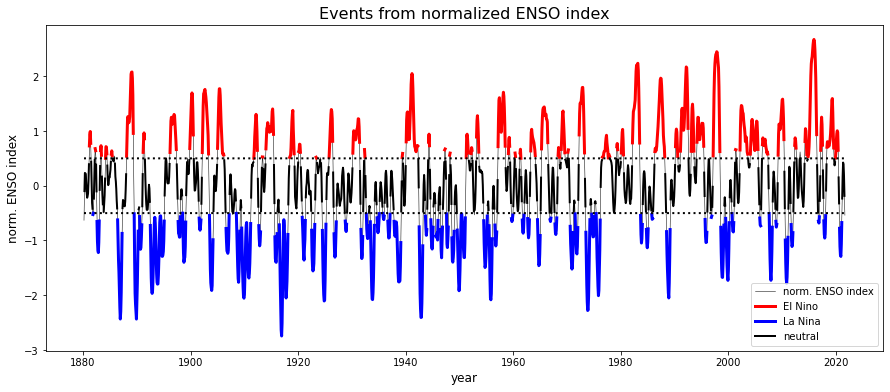

In [63]:
## Another way of highlighting distinct events:

# Mask events for plotting them in different colors
ENSO_ElNino = np.ma.masked_where(ENSO_index_norm.values < 0.5, ENSO_index_norm.values)
ENSO_LaNina = np.ma.masked_where(ENSO_index_norm.values > -0.5, ENSO_index_norm.values)
ENSO_neutral = np.ma.masked_where((ENSO_index_norm.values >= 0.5) | (ENSO_index_norm.values <= -0.5), ENSO_index_norm.values)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(ENSO_index_norm.time, ENSO_index_norm, label='norm. ENSO index', color='black', linewidth=0.5)
axes.plot(ENSO_index_norm.time, ENSO_ElNino, label='El Nino', color='red', linewidth=3)
axes.plot(ENSO_index_norm.time, ENSO_LaNina, label='La Nina', color='blue', linewidth=3)
axes.plot(ENSO_index_norm.time, ENSO_neutral, label='neutral', color='black', linewidth=2)

axes.set_xlabel("year", fontsize=12)
axes.set_ylabel("norm. ENSO index", fontsize=12)
axes.set_title("Events from normalized ENSO index", fontsize=16)
axes.legend()

# Add horizontal lines
axes.plot(ENSO_index_norm.time,0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)
axes.plot(ENSO_index_norm.time,-0.5 * np.ones(len(ENSO_index_norm)),'k:', linewidth=2)

plt.show

In [64]:
### Set some of the parameters up-front for splitting timeseries:

## Verbosity:
verbose = True

## Parameters for decomposing and splitting timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
scaled_YN = False # If True: Scale input series with min/max scaling, where min/max are taken only from train data!

In [107]:
# Split normalized ENSO index to train/val input/target:
train_input, val_input, train_target, val_target, train_min, train_max = split_data(ENSO_index_norm.values,
                                                                                    input_length=input_length,
                                                                                    target_length=target_length,
                                                                                    time_lag=0, 
                                                                                    train_val_split=0.8,
                                                                                    val_samples_from='end',
                                                                                    abs_to_rel_YN=False,
                                                                                    binary_YN=False,
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

raw data shape:  (1699,)
train_input shape:  (1351, 10, 1)
val_input shape:  (338, 10, 1)
train_target shape:  (1351, 1)
val_target shape:  (338, 1)
train_min:  0
train_max:  0


In [66]:
### Try to model normalized ENSO index with base ESN. Define parameters for ESN model upfront

n_layers = 1 # Number of ESN layers in the model.
n_res = 100 # Number of reservoir units.
W_in_lim = 1.0 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
spec_radius = 0.9 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 1 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

In [67]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpfr9ayp9b.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpfr9ayp9b.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
esn (ESN)                    ((None, 10, 100), (None,  10300     
___________________________________________________

2022-03-03 16:30:06.400470: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

In [68]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)

# Extract output weights and bias.
# Note: output layer is the LAST layer of the model, find weights and bias at position "-2" and "-1", respectively.
model_weights = np.array(model.get_weights())
W_out = model_weights[-2]
b_out = model_weights[-1]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
print("\nb_out before training: \n", b_out)

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to final reservoir states.
X_add = np.ones((X_T_train.shape[0], 1))
print("\nX_add shape: ",  X_add.shape)

# Now add vector of ONEs as additional column to final reservoir states X_T_train.
X_T_train_prime = np.concatenate((X_T_train, X_add), axis=-1)
print("\nFinal reservoir states in augmented notation, shape: ", X_T_train_prime.shape)

# Then need pseudo-inverse of final reservoir states in augmented notation
X_inv_prime = np.linalg.pinv(X_T_train_prime)

# Then get output weights, in augmented notation
W_out_prime = np.matmul(X_inv_prime, train_target)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out_prime shape: ", W_out_prime.shape)

# Now split output weights in augmented notation into trained output weights W_out and output bias b_out.
W_out = W_out_prime[:-1,:]
b_out = W_out_prime[-1:,0]
#print("\nW_out: \n", W_out)
print("\ntrained b_out: \n", b_out)

# Integrate trained output weights and bias into model weights
model_weights[-2] = W_out
model_weights[-1] = b_out
model.set_weights(model_weights)

## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


shape of train input (samples, timesteps, features):  (1351, 10, 1)


2022-03-03 16:30:07.591615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


shape of model output X_T (samples, n_res):  (1351, 100)

W_out shape:  (100, 1)
b_out shape:  (1,)

b_out before training: 
 [0.76344705]

X_add shape:  (1351, 1)

Final reservoir states in augmented notation, shape:  (1351, 101)
train_input shape:  (1351, 10, 1)
train_target shape:  (1351, 1)
W_out_prime shape:  (101, 1)

trained b_out: 
 [53918.17790994]

shape of val input (samples, timesteps, features):  (338, 10, 1)
shape of train input (samples, timesteps, features):  (1351, 10, 1)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_965/2873165540.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of model predictions on validation input (samples, 1):  (338, 1)
shape of val targets (samples, 1):  (338, 1)

val_mae:  0.3393
train_mae:  0.1213


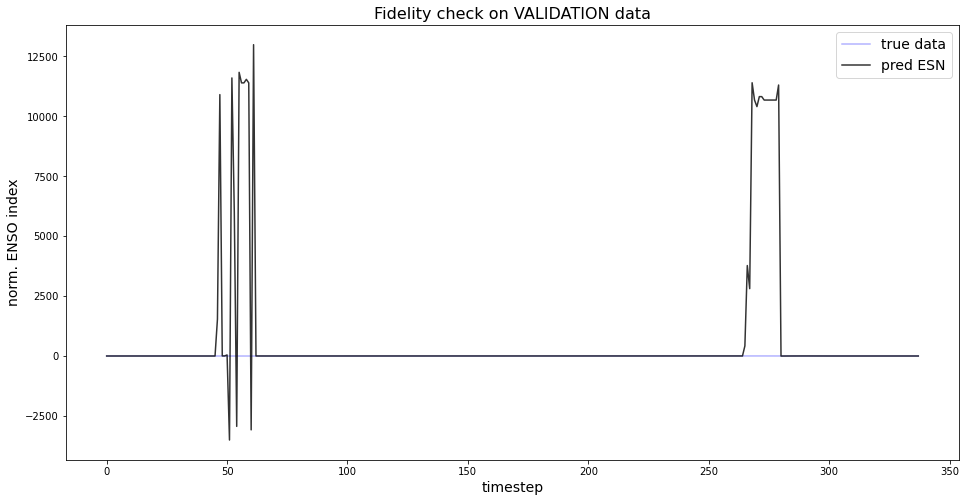

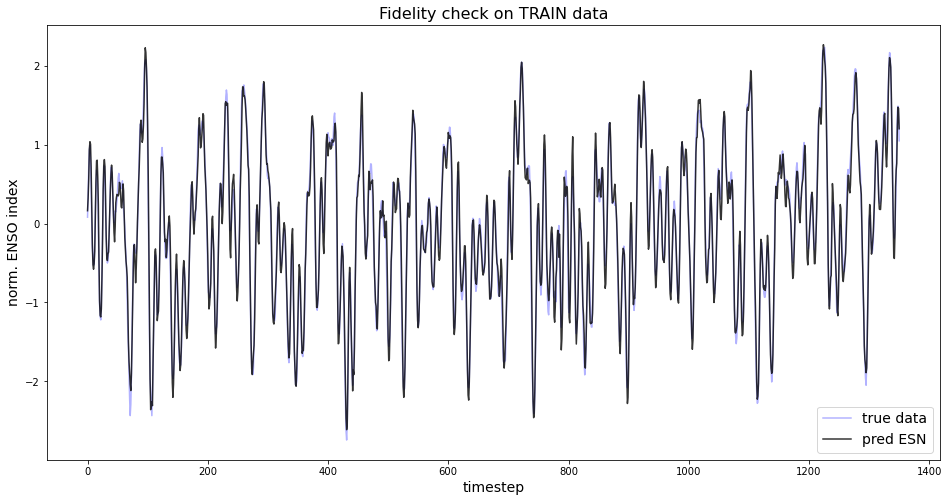

In [96]:
# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on TRAIN data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

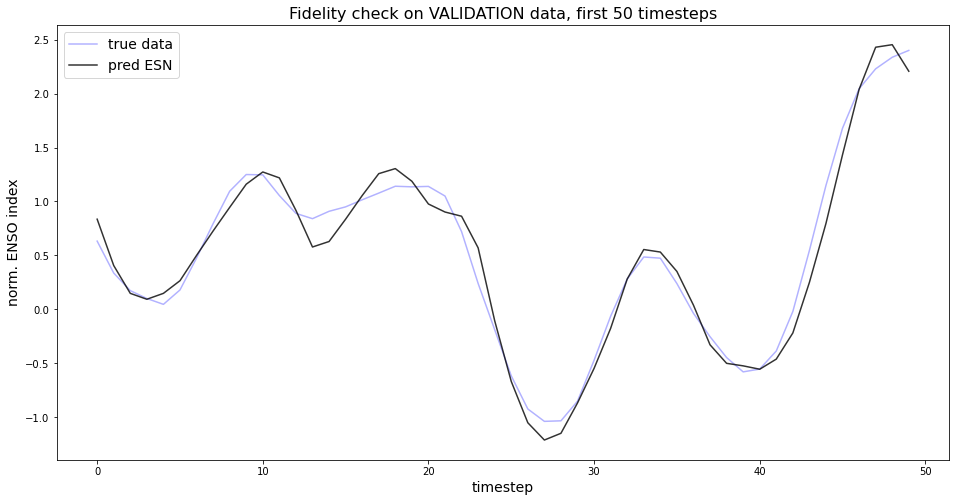

In [70]:
# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:50])),val_target[:50],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:50])),val_pred[:50],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [183]:
# Check accuracy: How often is the correct label predicted?
# Get number of events: Absolute and realtive to ALL events

print("\nnormalmized ENSO index")
print("======================")

print("\nTOTAL number of timesteps: ", len(ENSO_index_norm))
print("number of EL Nino events: ", np.sum(ENSO_index_norm.values>0.5))
print("number of La Nina events: ", np.sum(ENSO_index_norm.values<-0.5))
print("number of neutral events: ", np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)))

print("\nrel. amount of EL Nino events: ", np.round(np.sum(ENSO_index_norm.values>0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of La Nina events: ", np.round(np.sum(ENSO_index_norm.values<-0.5) / len(ENSO_index_norm)*100,1), "%")
print("rel. amount of neutral events: ", np.round(np.sum((ENSO_index_norm.values>=-0.5) & (ENSO_index_norm.values<=0.5)) / len(ENSO_index_norm)*100,1), "%")




normalmized ENSO index

TOTAL number of timesteps:  1699
number of EL Nino events:  549
number of La Nina events:  501
number of neutral events:  649

rel. amount of EL Nino events:  32.3 %
rel. amount of La Nina events:  29.5 %
rel. amount of neutral events:  38.2 %


In [71]:
# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
val_acc_neutral = sum((((val_pred>=-0.5) & (val_pred<=0.5)) == ((val_target>=-0.5) & (val_target<=0.5))) &
                       ((val_target>=-0.5) & (val_target<=0.5))) / sum(((val_target>=-0.5) & (val_target<=0.5)))

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))
train_acc_neutral = sum((((train_pred>=-0.5) & (train_pred<=0.5)) == ((train_target>=-0.5) & (train_target<=0.5))) &
                       ((train_target>=-0.5) & (train_target<=0.5))) / sum(((train_target>=-0.5) & (train_target<=0.5)))

In [72]:
# Get accuracy for target_length=1
# Note: Accurace prediction means having a certain event (e.g. El Nino) and correctly predicting 
#       to have that same event.
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.92
La Nina:  0.84
neutral:  0.83

Train accuracy:
El Nino:  0.9
La Nina:  0.92
neutral:  0.88


In [165]:
# target_length=3
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.65
La Nina:  0.59
neutral:  0.79

Train accuracy:
El Nino:  0.74
La Nina:  0.79
neutral:  0.79


In [185]:
# target_length=6
print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino[0],2))
print("La Nina: ", np.round(val_acc_LaNina[0],2))
print("neutral: ", np.round(val_acc_neutral[0],2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino[0],2))
print("La Nina: ", np.round(train_acc_LaNina[0],2))
print("neutral: ", np.round(train_acc_neutral[0],2))


Validation accuracy:
El Nino:  0.44
La Nina:  0.47
neutral:  0.66

Train accuracy:
El Nino:  0.5
La Nina:  0.56
neutral:  0.67


In [127]:
## Try multistep prediction with a sequence of one-step predictions with target_length=1 in free-float modus:
## Feed prediction as new input for next step's prediction, hence no "teacher-forcing".
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)

# Set number of free-float timesteps:
n_steps = 6

# Copy original val_input, not to "destroy" it
val_input_temp = np.copy(val_input)

# Loop over desired number of free-float timesteps:
for step in range(n_steps):
    
    # Get prediction for current timestep
    val_pred = model.predict(val_input_temp)
    
    # If first timestep, initialize storage for prediction of ALL timesteps (val_samples, n_steps)
    if step == 0:
        val_pred_all = np.copy(val_pred)
    
    else:
        val_pred_all = np.concatenate([val_pred_all, val_pred], axis=-1)

    ## Create inputs for second timestep from two ingredients:
    # Take all but the first input timesteps from previous input samples:
    temp1 = np.copy(val_input[:,1:,0:1])

    # Reshape predictions from previous timestep:
    temp2 = np.reshape(val_pred,(val_pred.shape[0], 1, 1))

    # Concatenate both ingredients to create input for next timestep:
    val_input_temp = np.concatenate([temp1, temp2], axis=1)

print("shape of val_pred_all (samples, n_steps): ", val_pred_all.shape)


shape of val input (samples, timesteps, features):  (338, 10, 1)
shape of val_pred_all (samples, n_steps):  (338, 6)


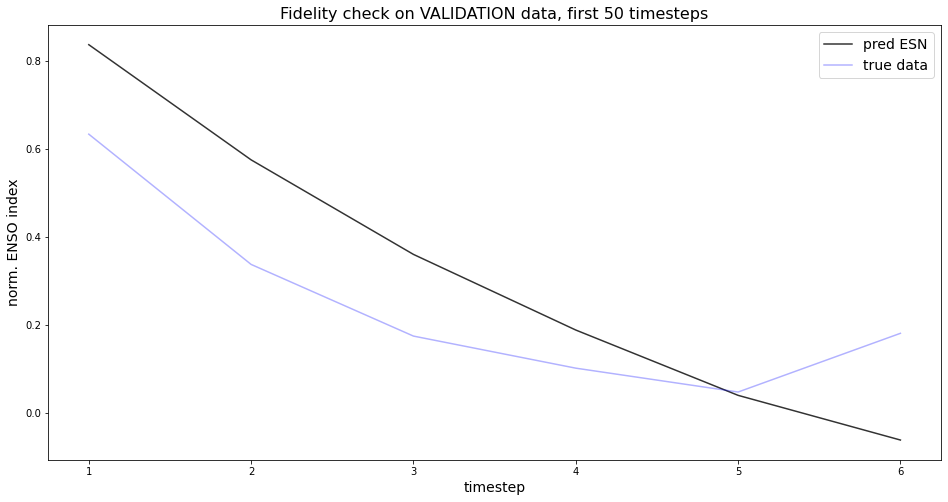

In [128]:
# Fidelity check: Plot free-float predictions vs. true validation targets

# sample
i = 0

plt.figure(figsize=(16,8))
plt.plot(range(1,n_steps+1),val_pred_all[i],'k',label="pred ESN", alpha=0.8)
plt.plot(range(1,n_steps+1),val_target[i:i+n_steps,0],'b',label="true data", alpha=0.3)
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

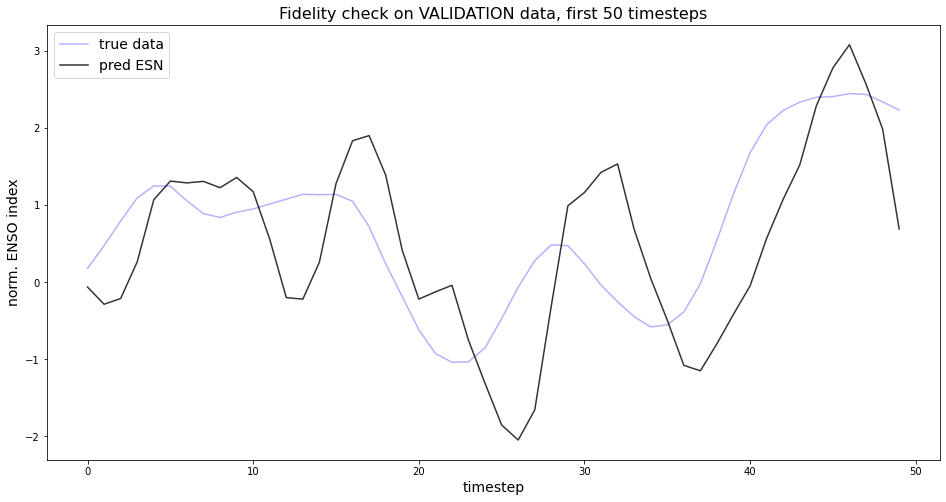

In [124]:
# look at timestep j
j = 5

# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[j:50+j])),val_target[j:50+j],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_all[:50,j])),val_pred_all[:50,j],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('norm. ENSO index', fontsize=14)
plt.legend(fontsize=14)
plt.show()